# Sorting sentiments of hotel reviews through machine learning

Welcome to my (admittedly very basic) machine learning project! Here we'll 
collect our own dataset of hotel reviews, then analyse the dataset, and lastly
build machine learning models to predict hotels' sentiment!

## Imports

Before we begin, let's settle all our imports!

In [105]:
# Essentials
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

import os
import zipfile

sns.set_theme(style="darkgrid", context="notebook")
%matplotlib inline

In [106]:
# NLP

import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TreebankWordTokenizer

from langdetect import detect


from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

In [148]:
# Machine learning
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
)


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
)

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

## Collecting our dataset

Let's start by collecting our dataset of hotel reviews. We're using Datafiniti's
[Hotel Reviews](https://www.kaggle.com/datasets/datafiniti/hotel-reviews) dataset
from Kaggle.

We're starting by analysing each review separately. We **tokenise** each
review (split it into individual words) and rank each token's sentiment on a numerical
scale using the [VADER](https://github.com/cjhutto/vaderSentiment) lexicon.

Before you run this code, make sure you've got the Kaggle commandline API
installed.

In [108]:
!kaggle d download datafiniti/hotel-reviews --force

with zipfile.ZipFile('hotel-reviews.zip', 'r') as zipdata:
    zipdata.extractall(os.path.join(os.path.abspath(os.path.dirname("")),'../data'))


  0%|          | 0.00/13.1M [00:00<?, ?B/s]
  8%|▊         | 1.00M/13.1M [00:00<00:11, 1.05MB/s]
 15%|█▌        | 2.00M/13.1M [00:01<00:05, 2.03MB/s]
 31%|███       | 4.00M/13.1M [00:01<00:02, 3.93MB/s]
 38%|███▊      | 5.00M/13.1M [00:01<00:01, 4.75MB/s]
 46%|████▌     | 6.00M/13.1M [00:01<00:01, 5.18MB/s]
 54%|█████▎    | 7.00M/13.1M [00:01<00:01, 5.68MB/s]
 61%|██████    | 8.00M/13.1M [00:01<00:00, 5.94MB/s]
 77%|███████▋  | 10.0M/13.1M [00:02<00:00, 6.80MB/s]
 84%|████████▍ | 11.0M/13.1M [00:02<00:00, 6.47MB/s]
 92%|█████████▏| 12.0M/13.1M [00:02<00:00, 6.38MB/s]
 99%|█████████▉| 13.0M/13.1M [00:02<00:00, 6.21MB/s]
100%|██████████| 13.1M/13.1M [00:02<00:00, 4.92MB/s]


In [109]:
df = pd.read_csv(
    os.path.join(
        os.path.abspath(os.path.dirname("")),
        "../data/7282_1.csv",
    )
)

# Remove columns that aren't necessary
df = df.drop(
    columns=[
        "address",
        "categories",
        "city",
        "country",
        "latitude",
        "longitude",
        "name",
        "postalCode",
        "province",
        "reviews.date",
        "reviews.dateAdded",
        "reviews.doRecommend",
        "reviews.id",
        "reviews.userCity",
        "reviews.username",
        "reviews.userProvince",
    ],
    axis=1,
)

# Remove rows with NaN
df = df.dropna()

df.head(10)

,reviews.rating,reviews.text,reviews.title
0,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds
1,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!
2,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge
3,5.0,We stayed here for four nights in October. The...,Good location on the Lido.
4,5.0,We stayed here for four nights in October. The...,������ ���������������
5,5.0,We loved staying on the island of Lido! You ne...,Very nice hotel
6,4.0,Lovely view out onto the lagoon. Excellent vie...,Lovely view out onto the lagoon. Excellent view.
7,4.0,ottimo soggiorno e ottima sistemazione nei gio...,Lovely view out onto the lagoon. Excellent view.
8,3.0,Gnstiger Ausgangspunkt fr Venedig Besuche. Ruh...,G��nstige Lage
9,4.0,Lidoen er perfekt til et par dages ro og afsla...,Ro og hygge


We can see that the reviews at indices `7`, `8` and `9` aren't in English. We can
use `langdetect` to help us detect the language of the review, and then remove the 
ones that aren't in English.

In [110]:
def detect_lang(text):
    try:
        return detect(text)
    except Exception as e:
        return None


df["reviews.all"] = (
    df["reviews.text"] + " " + df["reviews.title"]
)
df["reviews.language"] = df["reviews.all"].apply(
    detect_lang
)
df = df[df["reviews.language"] == "en"]
df.head(10)

,reviews.rating,reviews.text,reviews.title,reviews.all,reviews.language
0,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,Pleasant 10 min walk along the sea front to th...,en
1,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top fl...,en
3,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,We stayed here for four nights in October. The...,en
4,5.0,We stayed here for four nights in October. The...,������ ���������������,We stayed here for four nights in October. The...,en
5,5.0,We loved staying on the island of Lido! You ne...,Very nice hotel,We loved staying on the island of Lido! You ne...,en
6,4.0,Lovely view out onto the lagoon. Excellent vie...,Lovely view out onto the lagoon. Excellent view.,Lovely view out onto the lagoon. Excellent vie...,en
11,3.0,It was ok hotel is nice from in and out but ro...,It was ok hotel is nice from in and out but room,It was ok hotel is nice from in and out but ro...,en
15,4.0,The hotel staff was very friendly and helpful....,Lugnet p�� Lido,The hotel staff was very friendly and helpful....,en
16,4.0,"Nice hotel , with very friendly staff and help...",Nice hotel with very friendly and helpful staff,"Nice hotel , with very friendly staff and help...",en
20,1.0,DON'T stay here unless you're less than 2 feet...,"Dungeons, Drain Flies and Centipedes",DON'T stay here unless you're less than 2 feet...,en


## Lexicon-based sentiment analysis

We can start using our lexicon to get a numerical value for each of the reviews'
sentiments. Let's create an instance of the VADER lexicon analyser and run it through
each and every review.

In [111]:
analyzer = SentimentIntensityAnalyzer()

df["reviews.score"] = df["reviews.all"].apply(
    lambda review: analyzer.polarity_scores(review)[
        "compound"
    ]
)



# Remove reviews with a score of 0, because they aren't in English
df = df[df["reviews.score"] != 0.0]


# Classify the reviews by polarity: 1 for positive, 0 for negative
df["reviews.polarity"] = df["reviews.score"].apply(
    # If the compound score is greater than 0, it's positive
    lambda score: int(score > 0.0)
)

df.head(10)

,reviews.rating,reviews.text,reviews.title,reviews.all,reviews.language,reviews.score,reviews.polarity
0,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,Pleasant 10 min walk along the sea front to th...,en,0.8924,1
1,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top fl...,en,0.9872,1
3,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,We stayed here for four nights in October. The...,en,0.9719,1
4,5.0,We stayed here for four nights in October. The...,������ ���������������,We stayed here for four nights in October. The...,en,0.9643,1
5,5.0,We loved staying on the island of Lido! You ne...,Very nice hotel,We loved staying on the island of Lido! You ne...,en,0.9838,1
6,4.0,Lovely view out onto the lagoon. Excellent vie...,Lovely view out onto the lagoon. Excellent view.,Lovely view out onto the lagoon. Excellent vie...,en,0.9670,1
11,3.0,It was ok hotel is nice from in and out but ro...,It was ok hotel is nice from in and out but room,It was ok hotel is nice from in and out but ro...,en,0.8402,1
15,4.0,The hotel staff was very friendly and helpful....,Lugnet p�� Lido,The hotel staff was very friendly and helpful....,en,0.9630,1
16,4.0,"Nice hotel , with very friendly staff and help...",Nice hotel with very friendly and helpful staff,"Nice hotel , with very friendly staff and help...",en,0.9694,1
20,1.0,DON'T stay here unless you're less than 2 feet...,"Dungeons, Drain Flies and Centipedes",DON'T stay here unless you're less than 2 feet...,en,0.8990,1


Let's check out how many positive and negative reviews we have, as rated by
the lexicon we're using.

Text(0.5, 1.0, 'Proportion of reviews by sentiment')

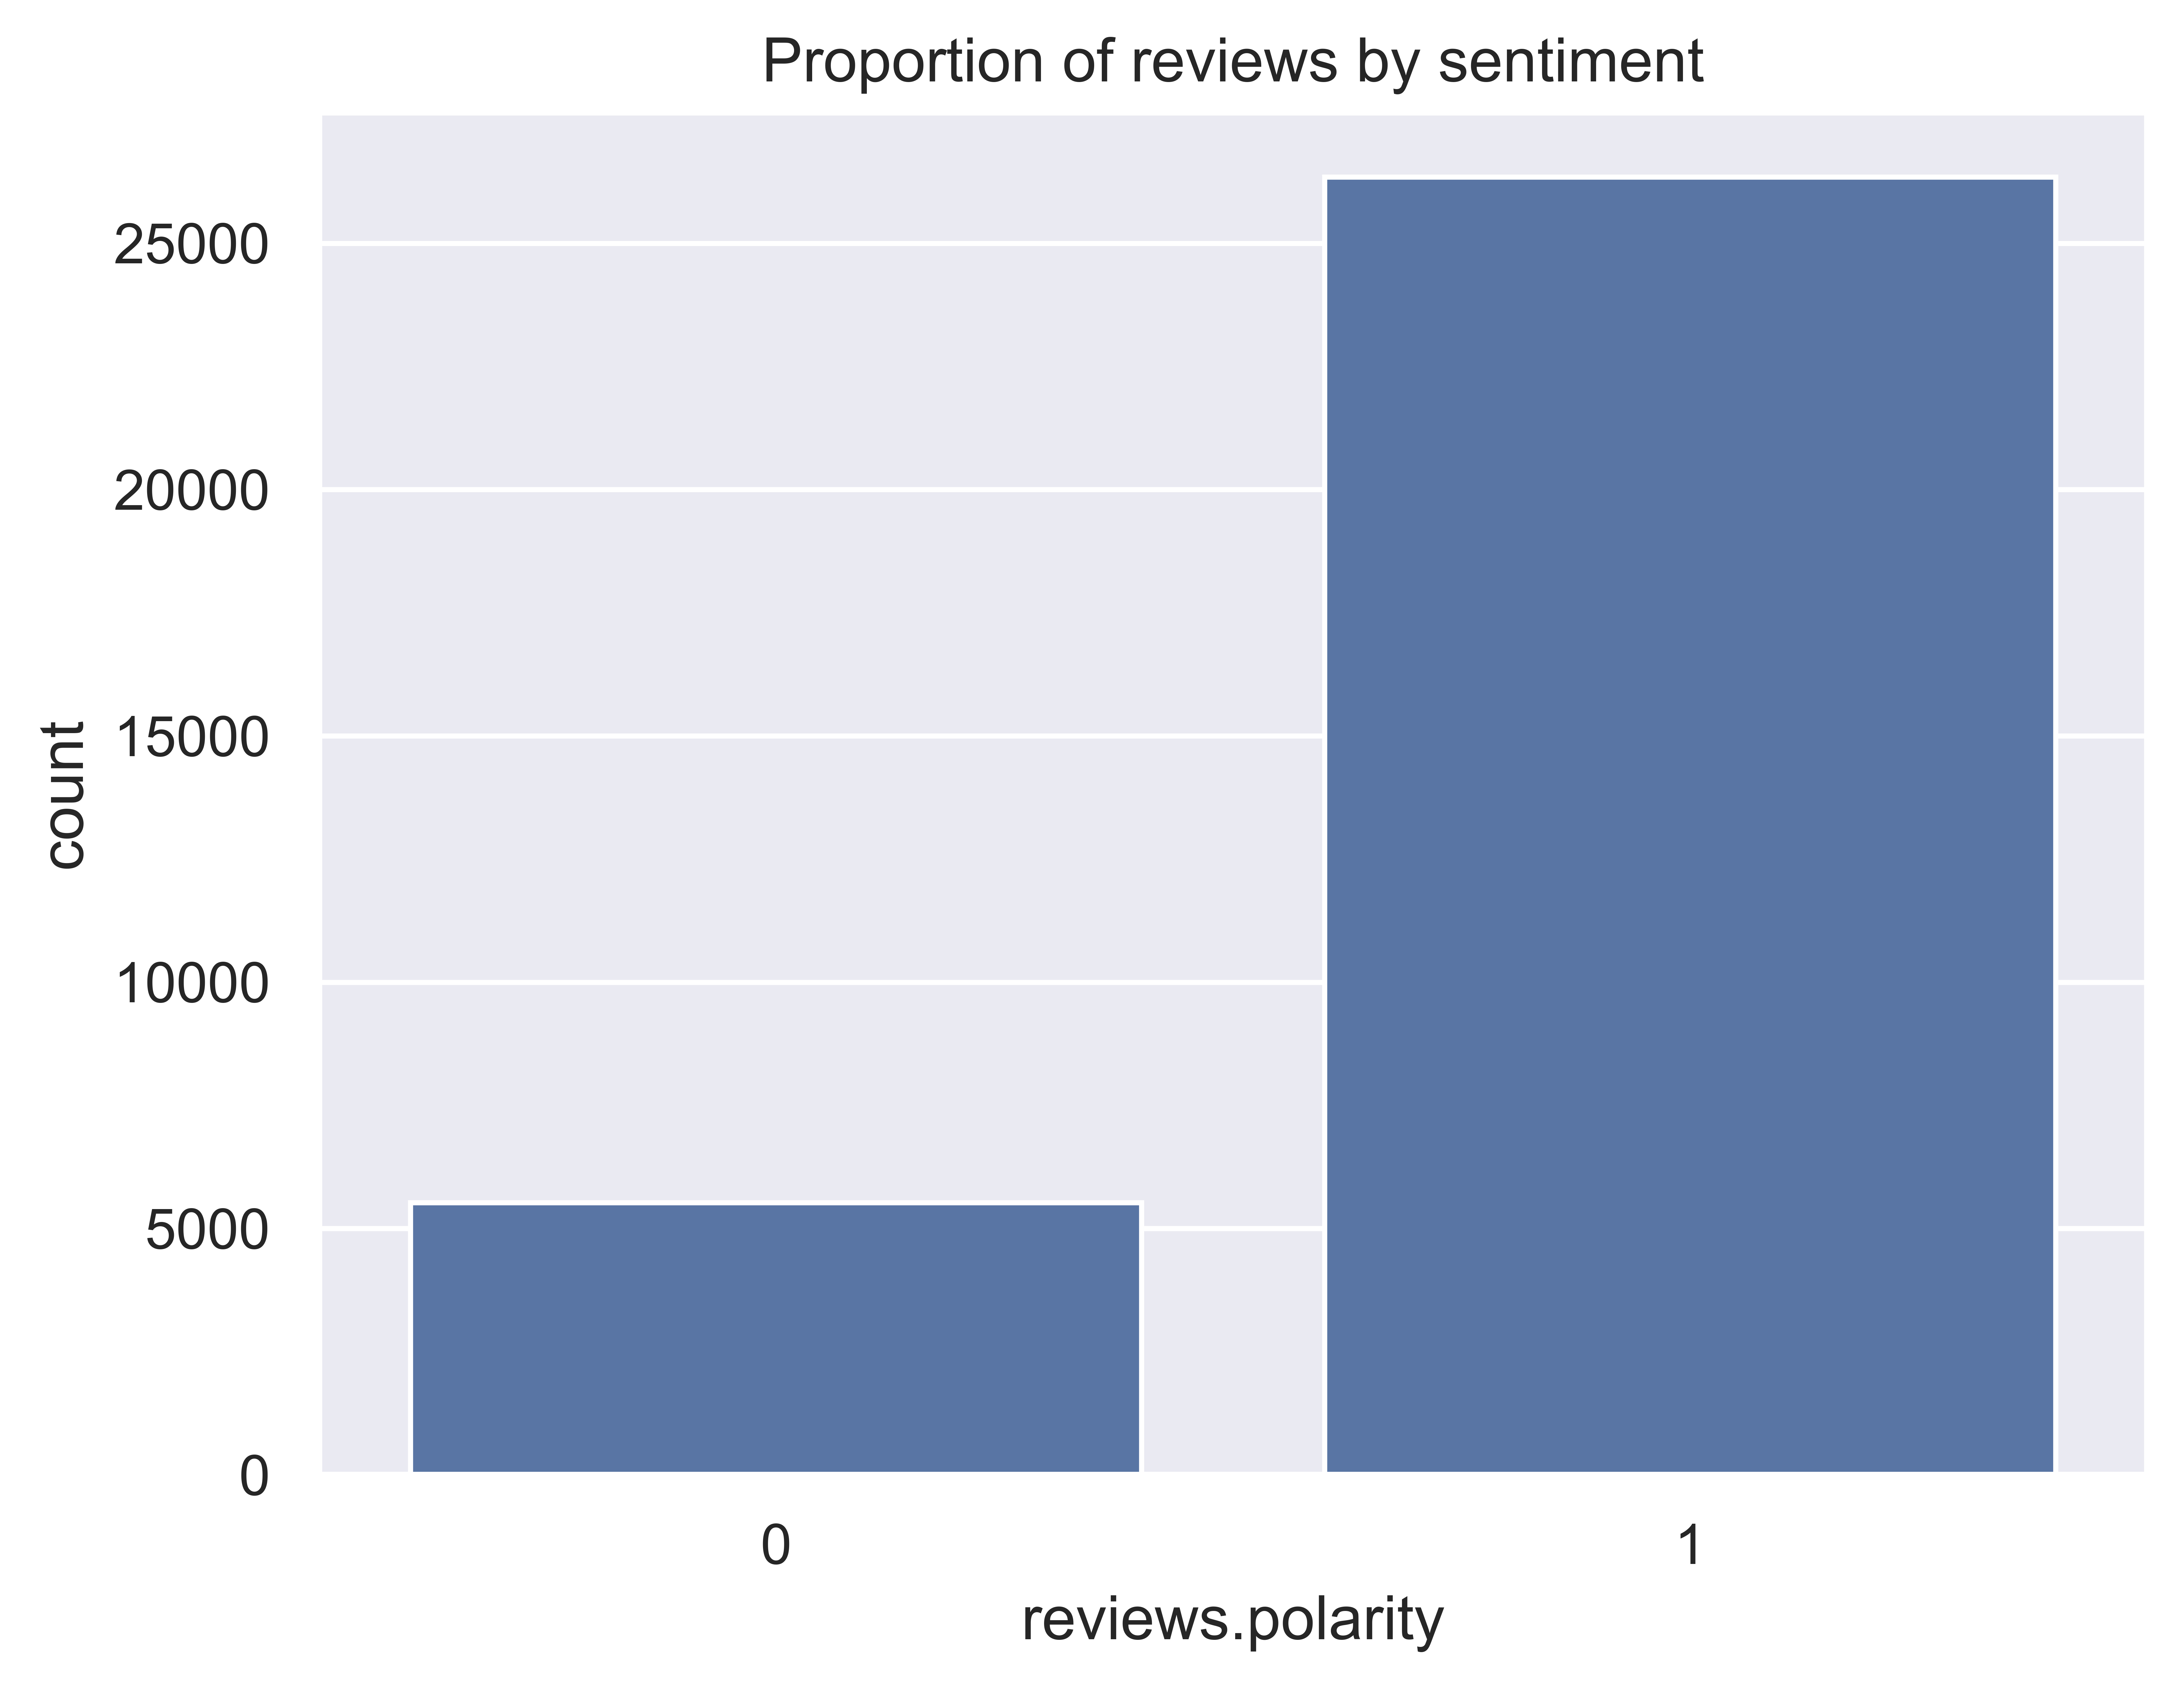

In [112]:
x_counts = df["reviews.polarity"].value_counts()
sns.barplot(x=x_counts.index, y=x_counts).set_title(
    "Proportion of reviews by sentiment"
)

## Data augmentation

There are _way_ more positive reviews than negative reviews. If we use this
training set to train our model, we might end up with a biased one. To avoid
this, let's use **data augmentation** to make sure we have an equal number of 
positive and negative reviews.

Before that, let's sample our minority class: the negative reviews.

In [113]:
"""
augmenter = naw.ContextualWordEmbsAug(
    model_path="bert-base-uncased", action="insert"
)
new_text = []

# Select the minority class
df_sampled = df[df["reviews.polarity"] == 0].reset_index(
    drop=True
)

df_sampled
"""

'\naugmenter = naw.ContextualWordEmbsAug(\n    model_path="bert-base-uncased", action="insert"\n)\nnew_text = []\n\n# Select the minority class\ndf_sampled = df[df["reviews.polarity"] == 0].reset_index(\n    drop=True\n)\n\ndf_sampled\n'

Let's take a random sampling from our negative reviews, and then augment it.
We then add our augmented text back into our dataset.

In [114]:
"""
# Augment our data
new_text = []

for idx in range(
    len(df[df["reviews.polarity"] == 1]) - len(df_sampled)
):
    augmented_text = augmenter.augment(
        df_sampled["reviews.text"][
            np.random.randint(0, len(df_sampled))
        ]
    )
    # Append our new data to the list of new text snippets
    new_text.append(augmented_text)

# Create a new dataframe with the augmented data
new_df = pd.DataFrame(
    {
        "reviews.text": new_text,
        "reviews.polarity": 0,
        "reviews.score": analyzer.polarity_scores(
            new_text
        )["compound"],
    }
)

df = pd.concat([df, new_df]).reset_index(drop=True)

# Shuffle our new data
df = df.sample(frac=1).reset_index(drop=True)

df[df["reviews.polarity"] == 0].head(10)
"""

'\n# Augment our data\nnew_text = []\n\nfor idx in range(\n    len(df[df["reviews.polarity"] == 1]) - len(df_sampled)\n):\n    augmented_text = augmenter.augment(\n        df_sampled["reviews.text"][\n            np.random.randint(0, len(df_sampled))\n        ]\n    )\n    # Append our new data to the list of new text snippets\n    new_text.append(augmented_text)\n\n# Create a new dataframe with the augmented data\nnew_df = pd.DataFrame(\n    {\n        "reviews.text": new_text,\n        "reviews.polarity": 0,\n        "reviews.score": analyzer.polarity_scores(\n            new_text\n        )["compound"],\n    }\n)\n\ndf = pd.concat([df, new_df]).reset_index(drop=True)\n\n# Shuffle our new data\ndf = df.sample(frac=1).reset_index(drop=True)\n\ndf[df["reviews.polarity"] == 0].head(10)\n'

Let's now examine how many positive and negative reviews we have.

In [115]:
"""
x_counts = df["reviews.polarity"].value_counts()
sns.barplot(x=x_counts.index, y=x_counts).set_title(
    "Proportion of reviews by sentiment (augmented)"
)
"""

'\nx_counts = df["reviews.polarity"].value_counts()\nsns.barplot(x=x_counts.index, y=x_counts).set_title(\n    "Proportion of reviews by sentiment (augmented)"\n)\n'

## Preprocessing

Now let's **tokenize** (split our reviews into words) and **lemmatize**
(get the root forms of words) our reviews, so that each review becomes
a string of lowercase words in their root forms.

This should make it much easier to turn them into numbers later.

In [116]:
# Collect words we want to exclude
ickwords = nltk.corpus.stopwords.words("english")

lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()


def cleanup(review: str) -> str:
    tokens = re.findall(r"[\w']+", review)
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    tokens = [
        token
        for token in tokens
        if token not in ickwords and token.isalpha()
    ]

    # Lemmatize
    tokens = [
        lemmatizer.lemmatize(token) for token in tokens
    ]
    return " ".join(tokens)


df["reviews.clean"] = df["reviews.all"].apply(cleanup)
df.head(10)

,reviews.rating,reviews.text,reviews.title,reviews.all,reviews.language,reviews.score,reviews.polarity,reviews.clean
0,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,Pleasant 10 min walk along the sea front to th...,en,0.8924,1,pleasant min walk along sea front water bus re...
1,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top fl...,en,0.9872,1,really lovely hotel stayed top floor surprised...
3,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,We stayed here for four nights in October. The...,en,0.9719,1,stayed four night october hotel staff welcomin...
4,5.0,We stayed here for four nights in October. The...,������ ���������������,We stayed here for four nights in October. The...,en,0.9643,1,stayed four night october hotel staff welcomin...
5,5.0,We loved staying on the island of Lido! You ne...,Very nice hotel,We loved staying on the island of Lido! You ne...,en,0.9838,1,loved staying island lido need take water veni...
6,4.0,Lovely view out onto the lagoon. Excellent vie...,Lovely view out onto the lagoon. Excellent view.,Lovely view out onto the lagoon. Excellent vie...,en,0.9670,1,lovely view onto lagoon excellent view staff w...
11,3.0,It was ok hotel is nice from in and out but ro...,It was ok hotel is nice from in and out but room,It was ok hotel is nice from in and out but ro...,en,0.8402,1,ok hotel nice room small paid double bed bat a...
15,4.0,The hotel staff was very friendly and helpful....,Lugnet p�� Lido,The hotel staff was very friendly and helpful....,en,0.9630,1,hotel staff friendly helpful room clean comfor...
16,4.0,"Nice hotel , with very friendly staff and help...",Nice hotel with very friendly and helpful staff,"Nice hotel , with very friendly staff and help...",en,0.9694,1,nice hotel friendly staff helpful great choice...
20,1.0,DON'T stay here unless you're less than 2 feet...,"Dungeons, Drain Flies and Centipedes",DON'T stay here unless you're less than 2 feet...,en,0.8990,1,stay unless le foot tall like sleeping centipe...


## Vectorization

Let's set our independent and dependent variables: the cleaned review
and the review's polarity respectively.

Now let's extract numerical representations for each of our reviews. We'll
use TF-IDF values (term frequency-inverse document frequency values) to measure
how frequently a token appears in a review, relative to other tokens in the same
review.

In [117]:
x = df["reviews.clean"]
y = df["reviews.polarity"]

x.head(10)

0     pleasant min walk along sea front water bus re...
1     really lovely hotel stayed top floor surprised...
3     stayed four night october hotel staff welcomin...
4     stayed four night october hotel staff welcomin...
5     loved staying island lido need take water veni...
6     lovely view onto lagoon excellent view staff w...
11    ok hotel nice room small paid double bed bat a...
15    hotel staff friendly helpful room clean comfor...
16    nice hotel friendly staff helpful great choice...
20    stay unless le foot tall like sleeping centipe...
Name: reviews.clean, dtype: object

Now let's vectorize our reviews: turn them into numbers.

In [118]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(x)

vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaaahh', 'aafter', 'aarp', 'aaverage', 'ab', 'aback',
       'abandon', 'abandoned', 'abanico', 'abbott', 'abc', 'abd', 'aber',
       'aberdeen', 'aberration', 'abides', 'abilene', 'ability', 'abit',
       'abita', 'abiver', 'able', 'ablebodied', 'abmi', 'abo', 'aboard',
       'abode', 'abound', 'abounds', 'abq', 'abrasive', 'abroad',
       'abrupt', 'abruptly', 'absence', 'absense', 'absent', 'absolut',
       'absolute', 'absolutelt', 'absolutely', 'absolutley', 'absolutly',
       'absorb', 'absorbed', 'absorbent', 'absurd', 'absurdly', 'abt',
       'abundance', 'abundant', 'abuse', 'abut', 'abuts', 'abv', 'abvi',
       'abysmal', 'abysmally', 'ac', 'academy', 'acadia', 'acapulco',
       'accademia', 'acceces', 'accecptable', 'accelerated', 'accent',
       'accented', 'accept', 'acceptable', 'acceptably', 'accepted',
       'accepting', 'accepts', 'acces', 'accesible', 'accesories',
       'access', 'accessable', 'accessed', 'accessibility', 'accessibl',

## Model training

The time is finally right to begin training our models! Let's first split
the data we have into training and testing sets.

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Class weights

As you've probably seen before, the number of positive reviews far exceeds the
number of negative reviews. If we trained our model with our current data,
we might end up with a biased model: one that is more biased towards predicting 
the majority class (positive). 

Thus, we'll assign a weight to each class: a higher weight for the minority class,
and a lower weight for the majority class. To see which weights are best,
let's construct a classic logistic regression model to find our best weights.

To do this we'll make a large collection of possible weights our majority class
could take, from $0$ to $1$. Then we'll use grid searching to find the class
weight that produces the best F1 score.

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


Text(0.5, 1.0, 'F1 score for logistic regression model based on majority weight')

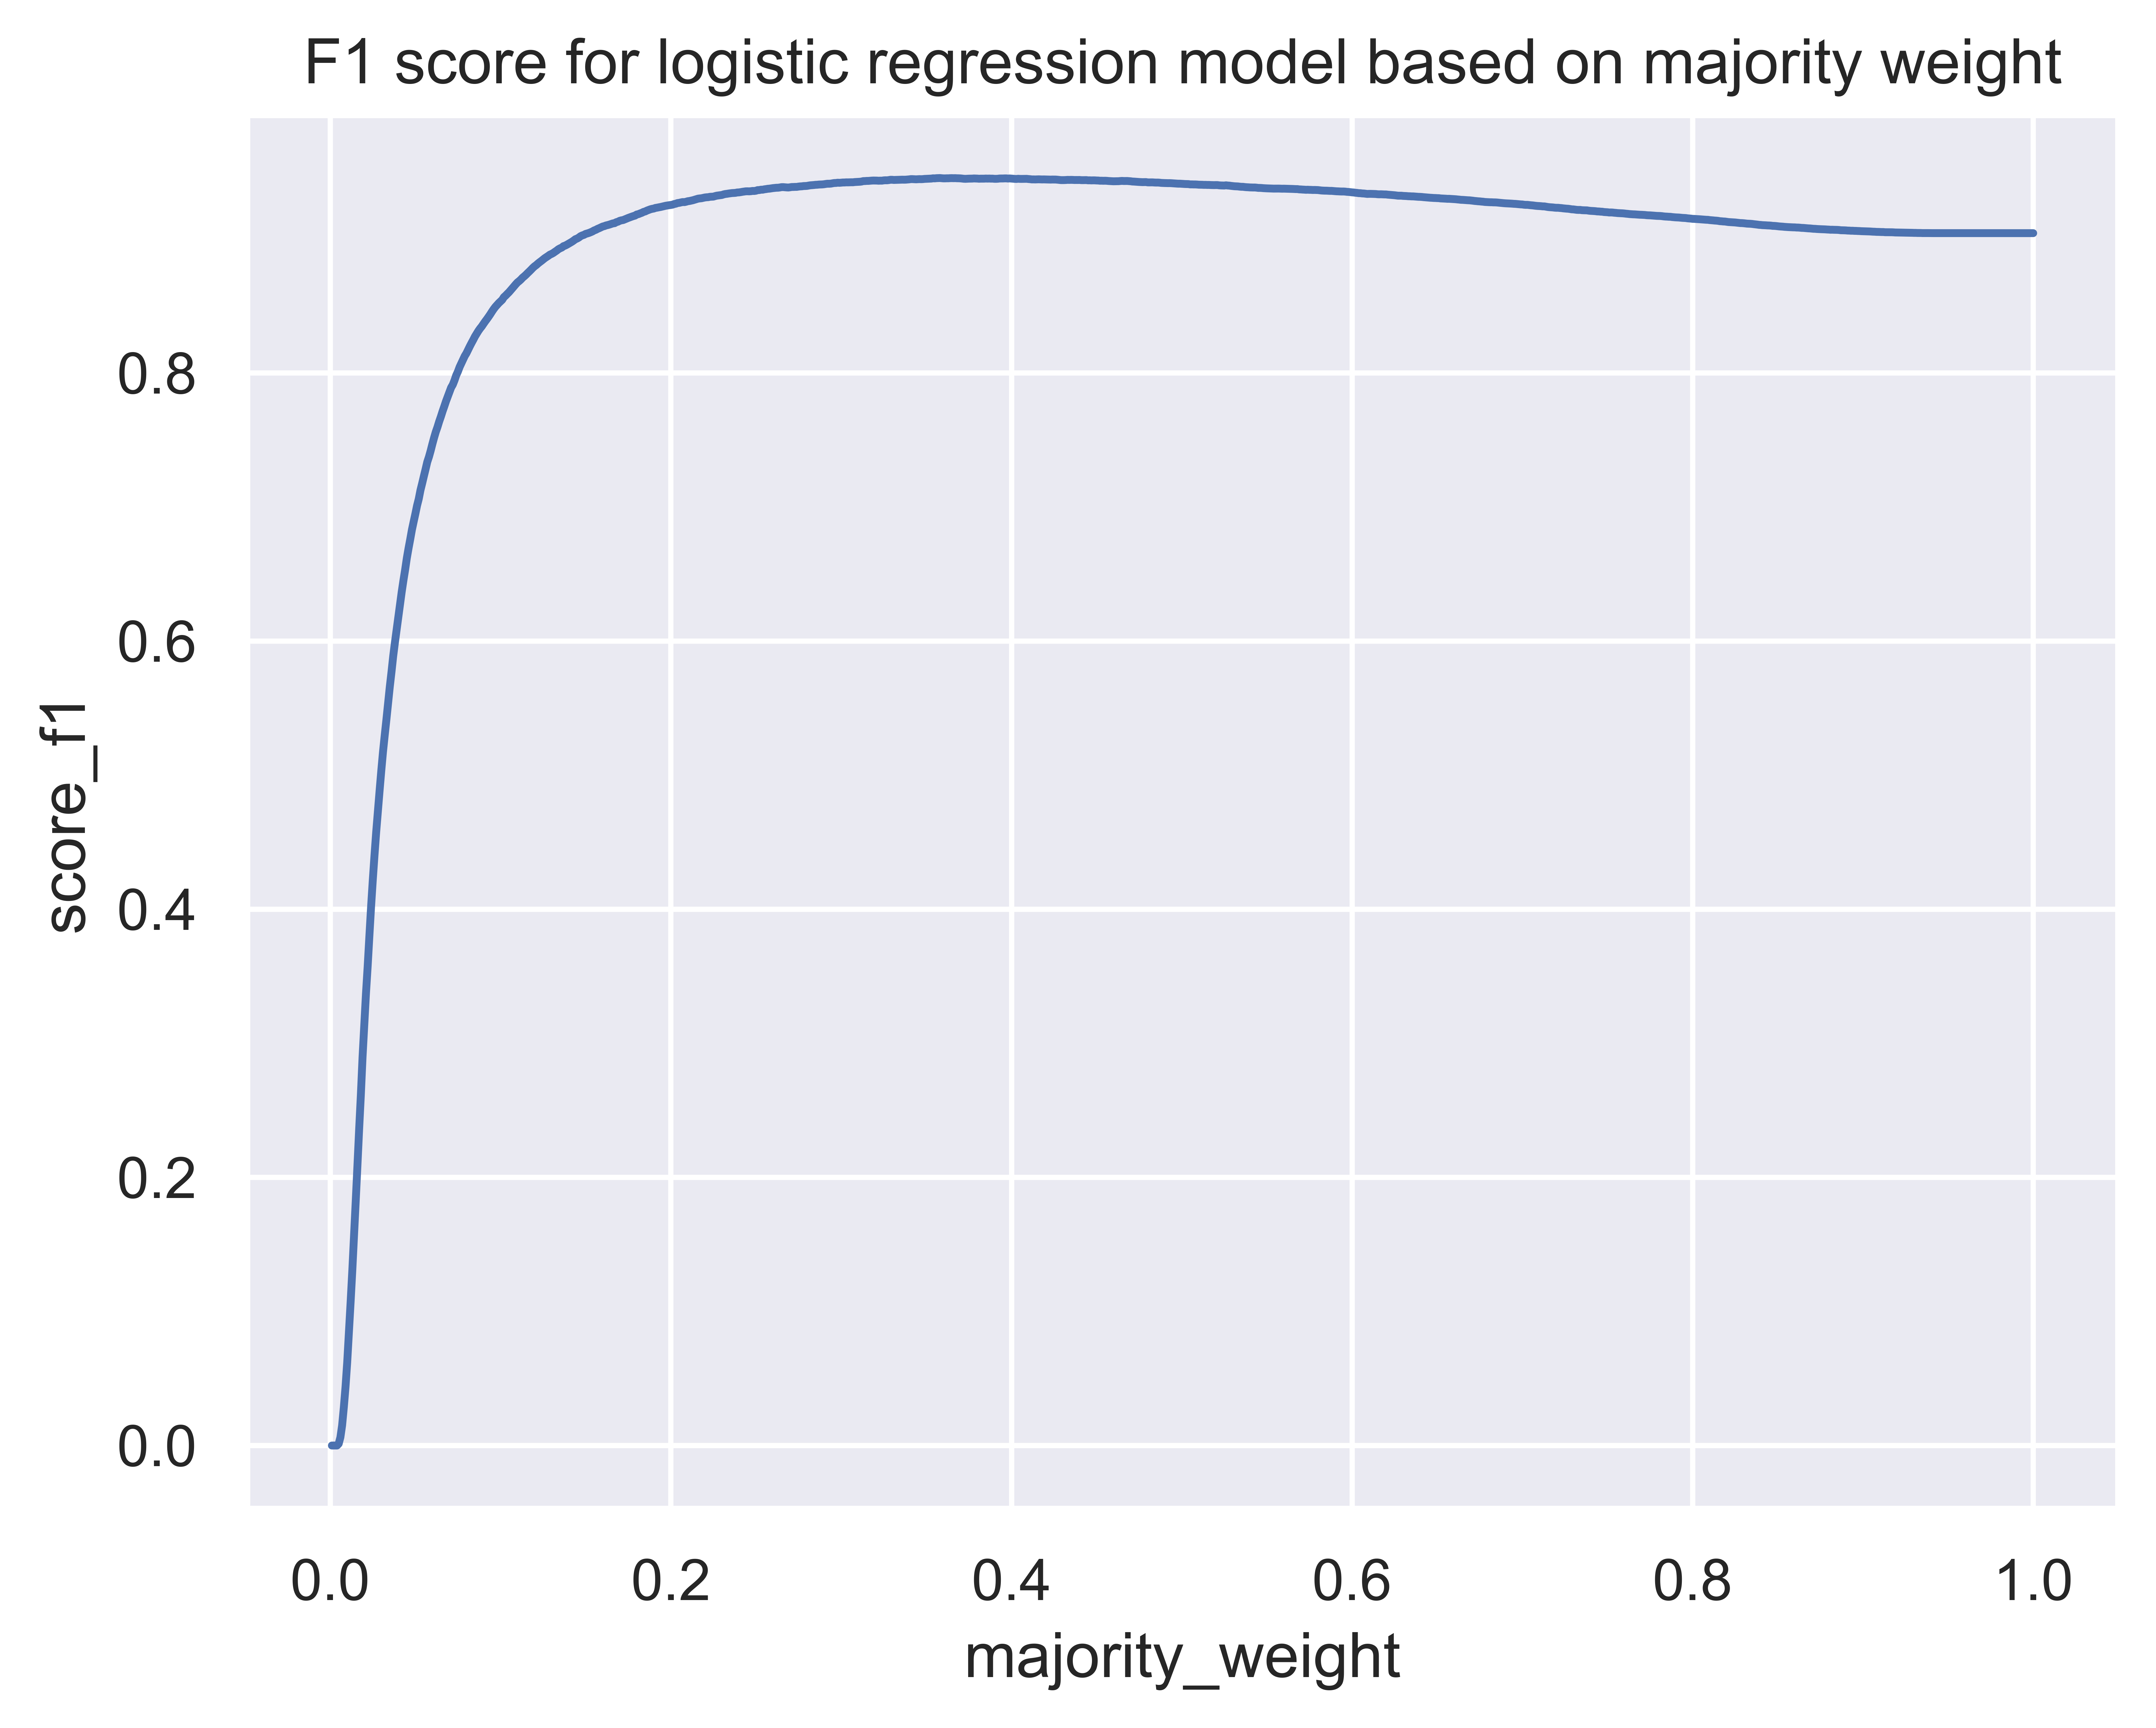

In [126]:
model_lr = LogisticRegression(
    solver="newton-cg", class_weight="balanced"
)
model_lr.fit(X_train, y_train)

potential_weights = np.linspace(0.0, 0.999, 1000)
param_grid = {
    "class_weight": [
        {0: weight, 1: 1.0 - weight}
        for weight in potential_weights
    ]
}

gridsearch = GridSearchCV(
    estimator=model_lr,
    param_grid=param_grid,
    cv=StratifiedKFold(),
    n_jobs=-1,
    scoring="f1",
    verbose=2,
).fit(X_train, y_train)

weight_tests = pd.DataFrame(
    {
        "score_f1": gridsearch.cv_results_[
            "mean_test_score"
        ],
        "majority_weight": (1 - potential_weights),
    }
)
sns.lineplot(
    x=weight_tests["majority_weight"],
    y=weight_tests["score_f1"],
).set_title(
    "F1 score for logistic regression model against majority class weight"
)

Our maximum F1 score with the logistic regression model
happens somewhere when the majority weight is approximately
$0.3$. Let's find the maximum with a bit of code.

In [128]:
f1_max = weight_tests["score_f1"].max()
best_weight = weight_tests[
    weight_tests["score_f1"] == f1_max
]["majority_weight"].values[0]

best_weight

0.358

This means that we should set the weight for our positive review class to $0.358$.

In [130]:
weights = {0: 1.0 - best_weight, 1: best_weight}

### Random forest classifier

Let's first create a random forest classifier, a classification model 
commonly used in text classification, like this. It's quite popular because
it yields high accuracies.

In [132]:
rf = RandomForestClassifier(n_estimators=100, class_weight=weights)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

c:\Users\geo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\class_weight.py:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weight[i] = class_weight[c]


              precision    recall  f1-score   support

           0       0.88      0.44      0.59      1072
           1       0.90      0.99      0.94      5303

    accuracy                           0.90      6375
   macro avg       0.89      0.72      0.77      6375
weighted avg       0.90      0.90      0.88      6375



Let's evaluate it on a few metrics. First, let's see a report on how it did
classifying our test data.

In [133]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.88      0.44      0.59      1072
           1       0.90      0.99      0.94      5303

    accuracy                           0.90      6375
   macro avg       0.89      0.72      0.77      6375
weighted avg       0.90      0.90      0.88      6375



Quite good! We have an F1 score of $0.94$ for the positive reviews, and high
precisions for both classes. Now let's see a confusion matrix.

In [142]:
rf_confusion = confusion_matrix(y_test, rf_preds)
rf_confusion

array([[ 475,  597],
       [  63, 5240]], dtype=int64)

array([[ 475,  597],
       [  63, 5240]], dtype=int64)

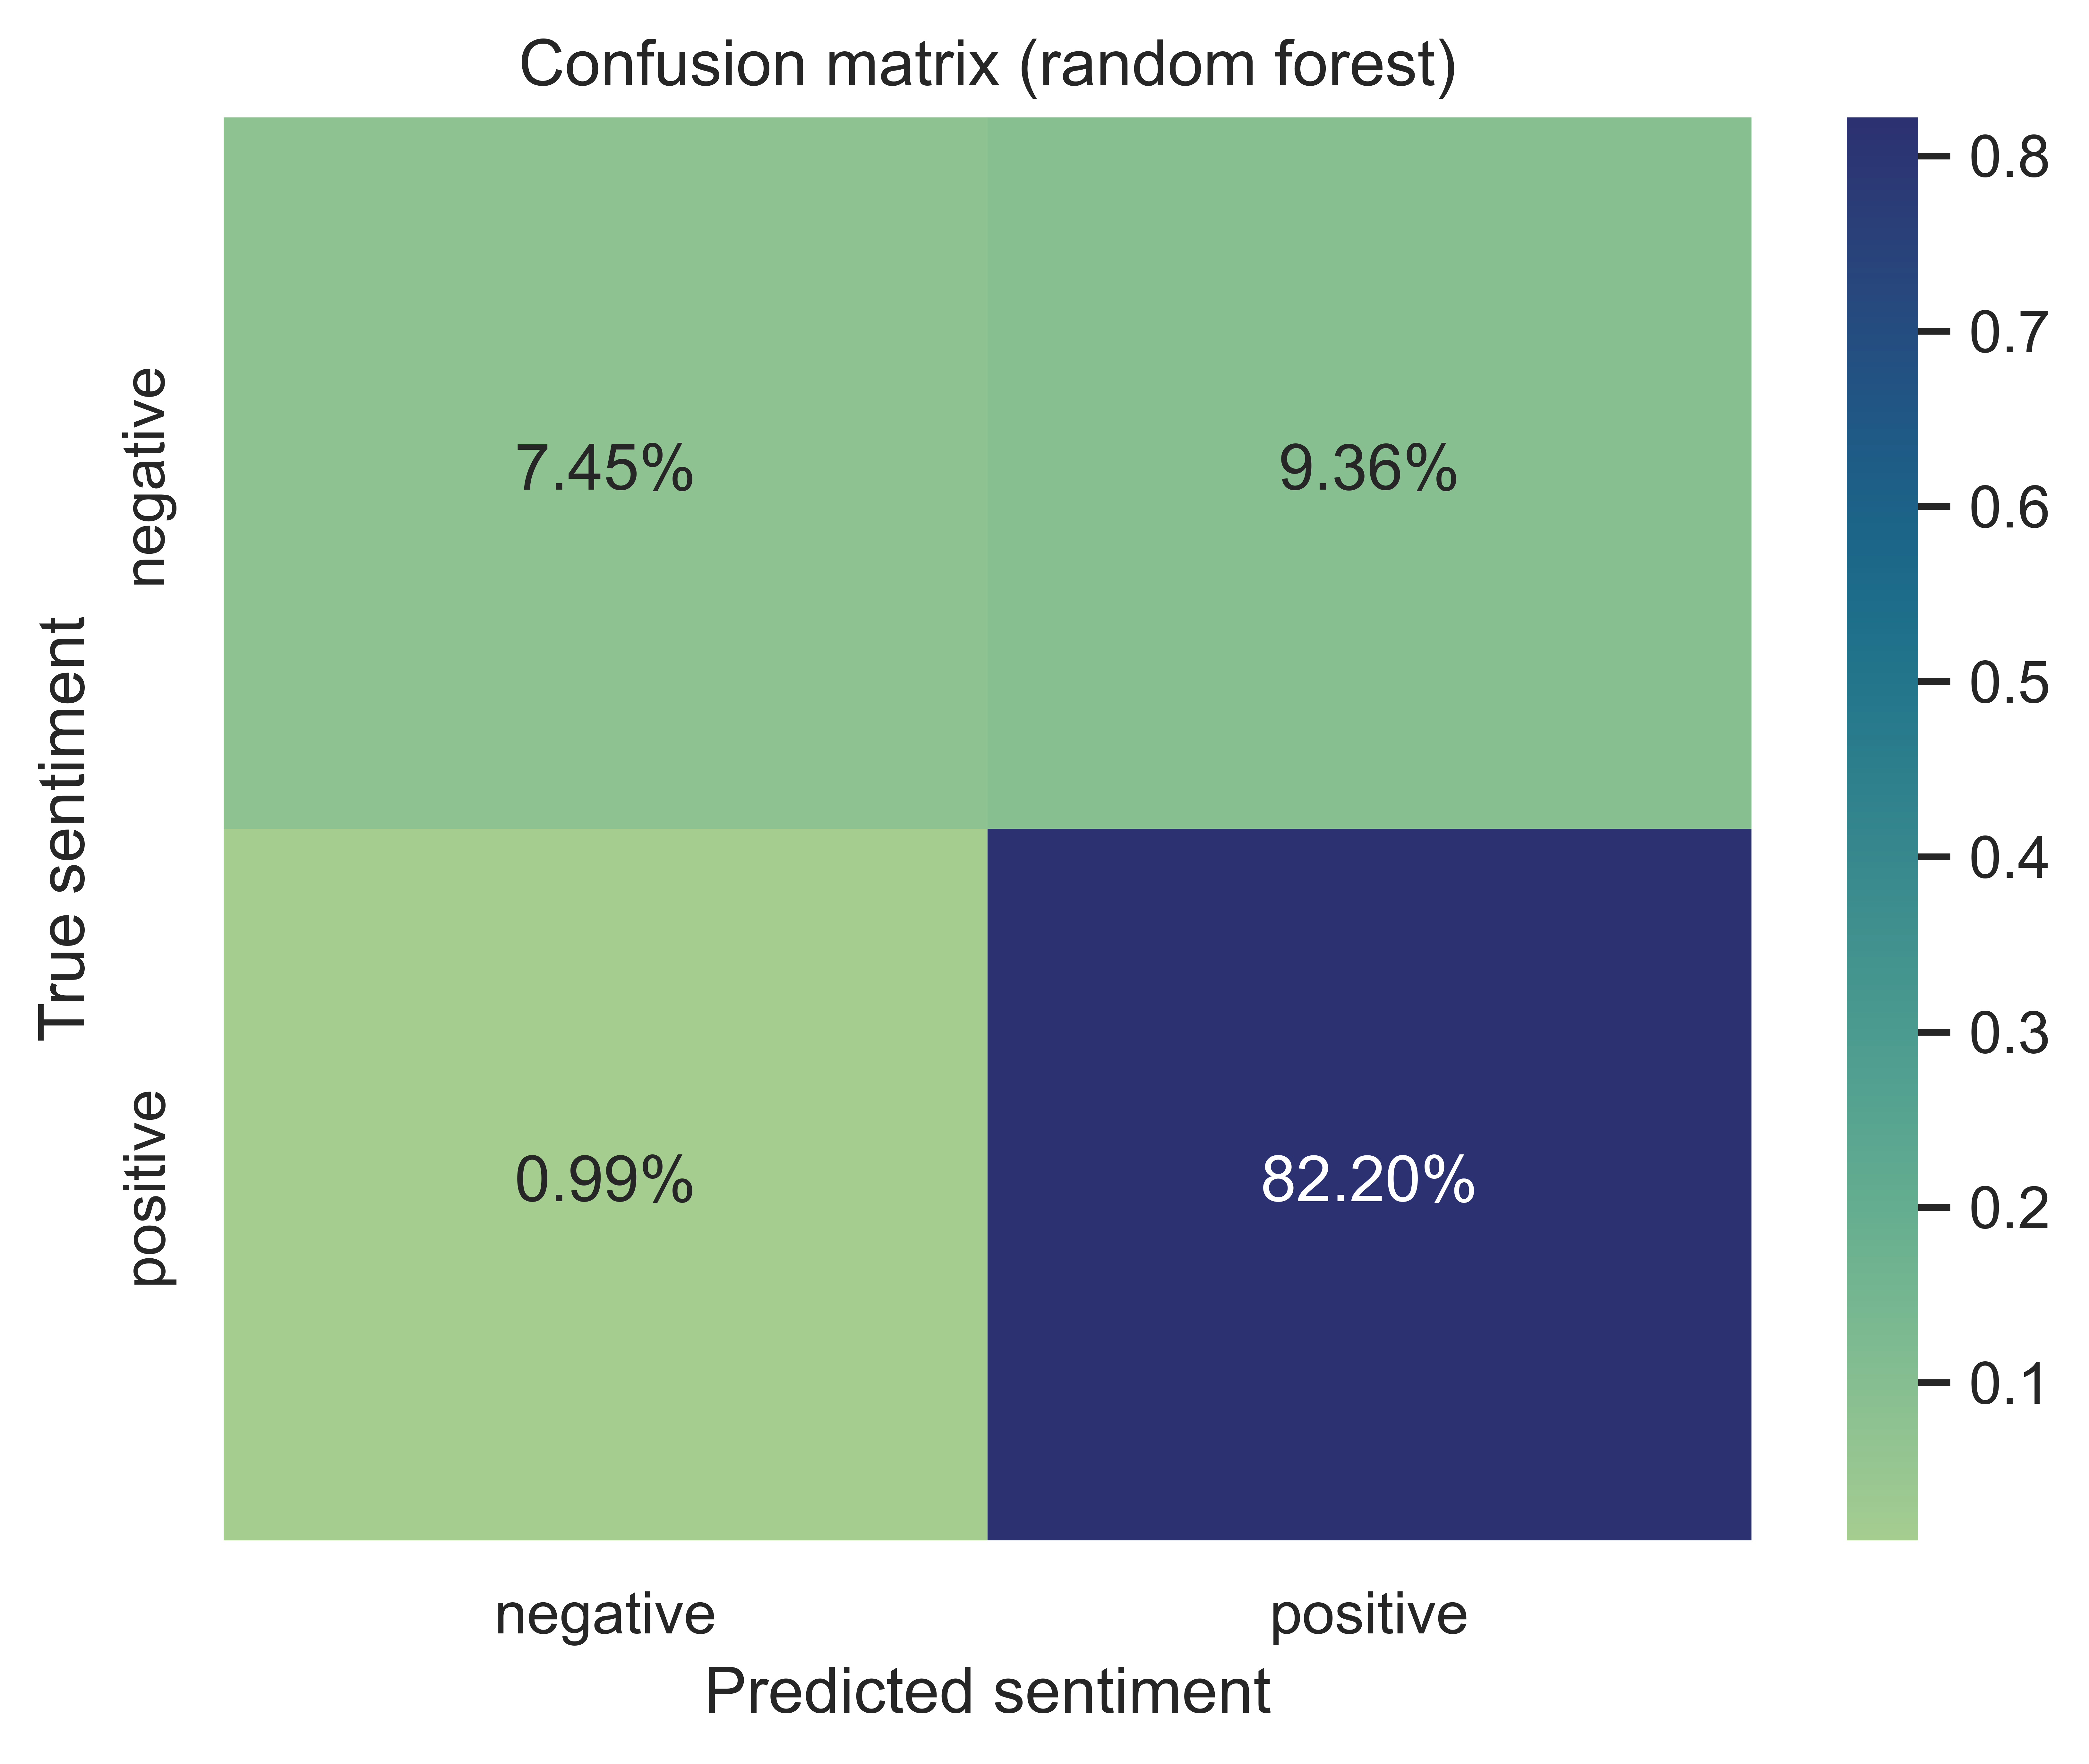

In [145]:
palette = sns.color_palette("crest", as_cmap=True)


def confused(truths, predictions, label: str):
    """Create a confusion matrix for the given truths and predictions."""
    confusion = confusion_matrix(truths, predictions)
    sns.heatmap(
        rf_confusion / np.sum(rf_confusion),
        fmt=".2%",
        annot=True,
        cmap=palette,
        xticklabels=["negative", "positive"],
        yticklabels=["negative", "positive"],
    ).set_title(f"Confusion matrix ({label})")
    plt.xlabel("Predicted sentiment")
    plt.ylabel("True sentiment")
    return confusion

confused(y_test, rf_preds, "random forest")

### Support vector machine (SVM)

Let's try a support vector machine next! They're also quite widely used within
the realm of text classification.

In [138]:
svm = SGDClassifier(loss="hinge", class_weight=weights)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)

c:\Users\geo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\class_weight.py:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weight[i] = class_weight[c]


Let's again test it with our metrics:

In [139]:
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1072
           1       0.94      0.95      0.95      5303

    accuracy                           0.91      6375
   macro avg       0.84      0.84      0.84      6375
weighted avg       0.91      0.91      0.91      6375



array([[ 777,  295],
       [ 275, 5028]], dtype=int64)

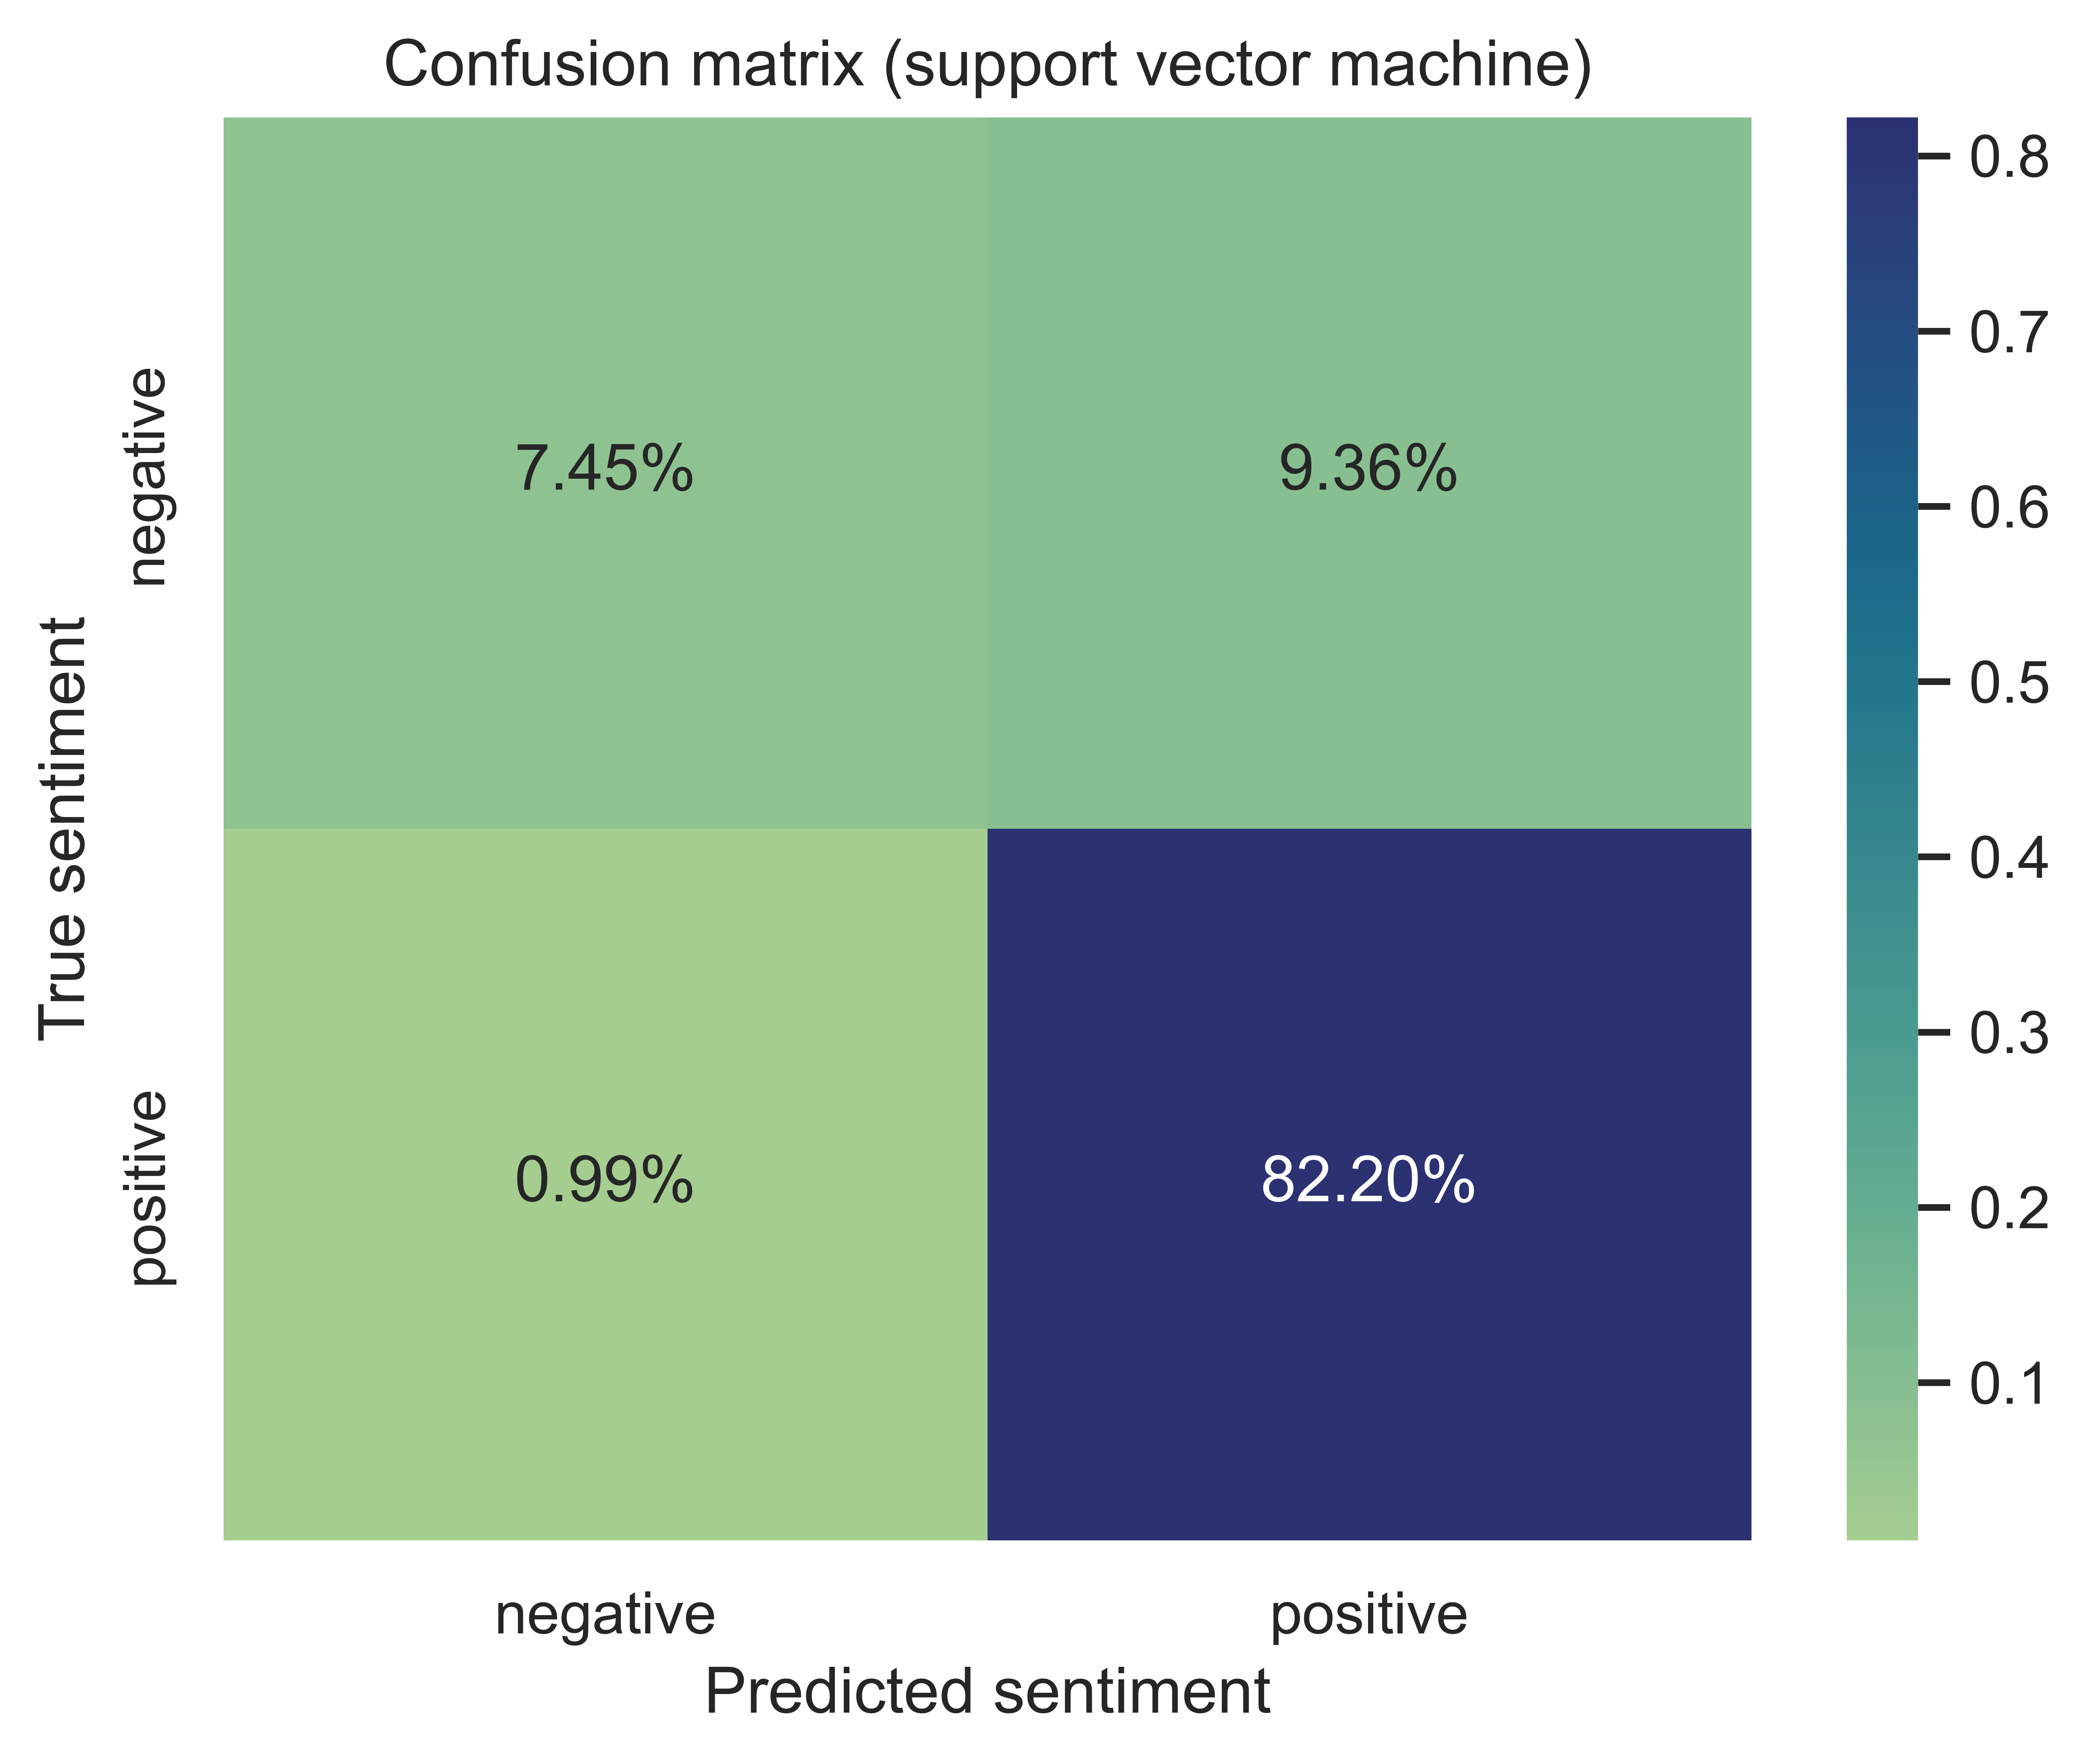

In [146]:
confused(y_test, svm_preds, "support vector machine")

### K nearest neighbours

Lastly, let's round this machine learning exercise off with a K nearest neighbours
(KNN) classifier. It's most commonly used in any type of classification problem,
so it's definitely worth a shot.

KNN doesn't rely on numerical weights as we've been using, but we can weigh
points based on the inverse of their distance. Let's use that then!

In [150]:
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)

Again, let's use the same metrics: a report and a confusion matrix:

In [151]:
print(classification_report(y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.71      0.39      0.50      1072
           1       0.89      0.97      0.93      5303

    accuracy                           0.87      6375
   macro avg       0.80      0.68      0.71      6375
weighted avg       0.86      0.87      0.85      6375



array([[ 415,  657],
       [ 166, 5137]], dtype=int64)

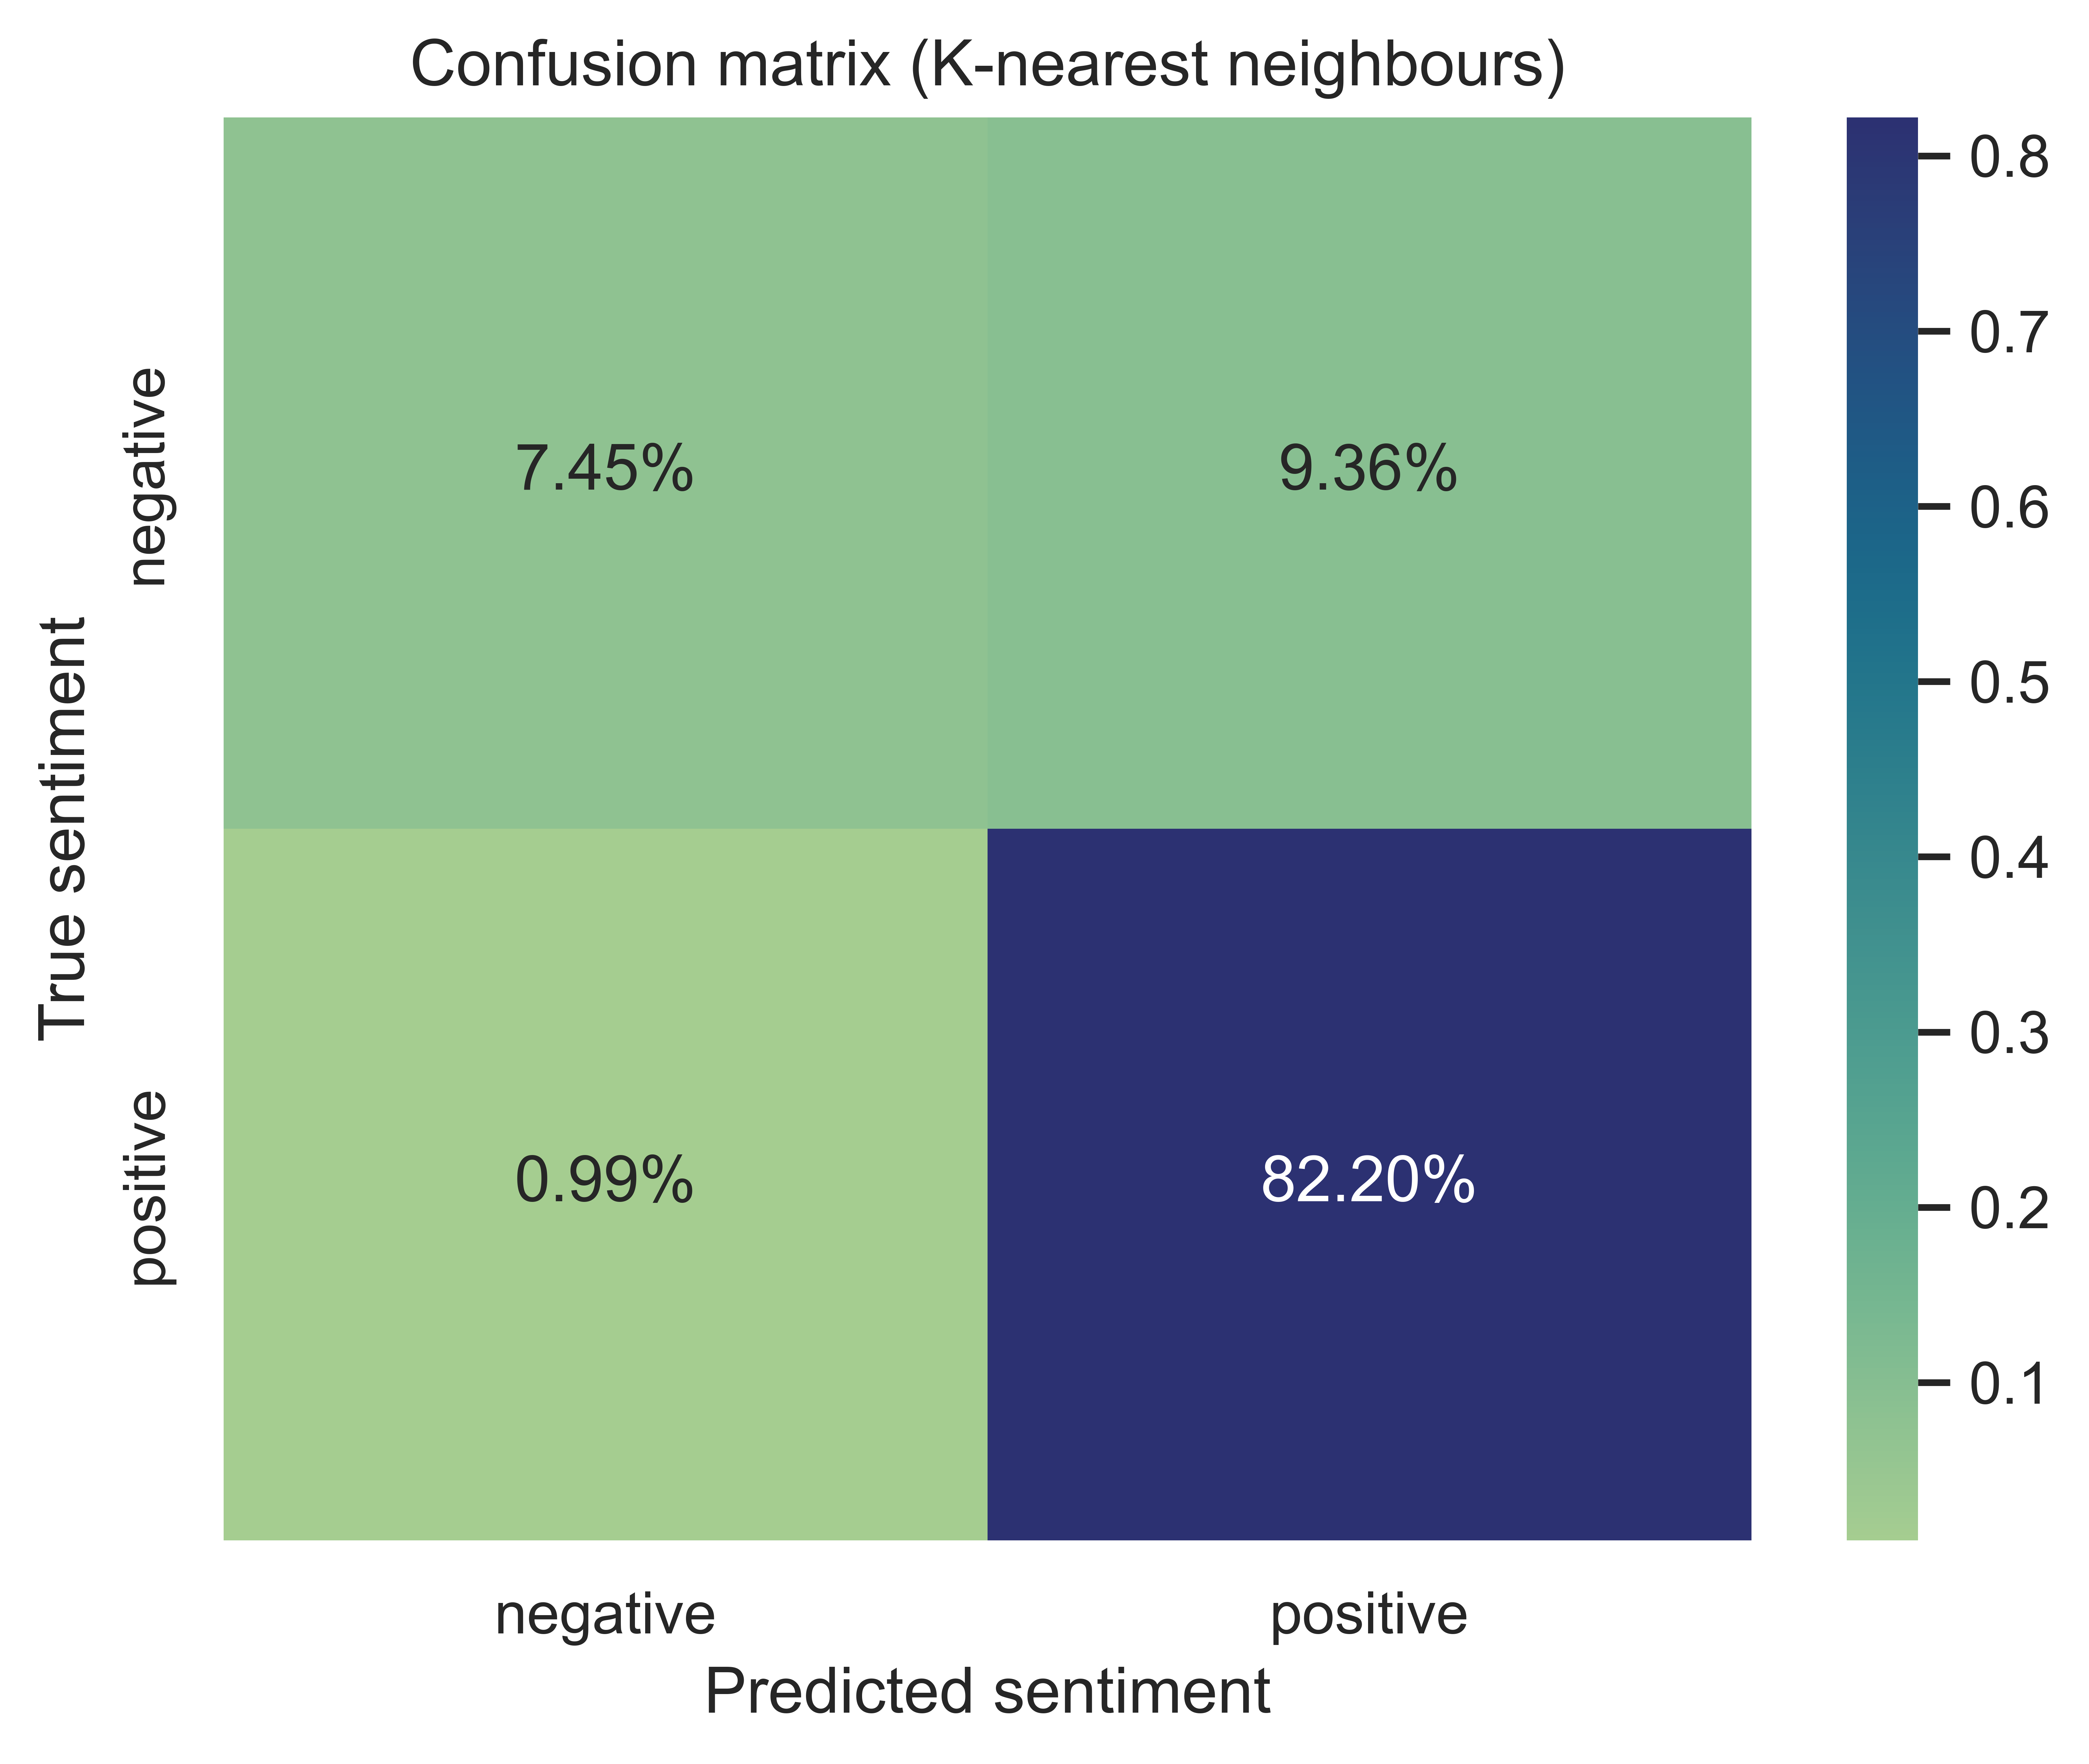

In [152]:
confused(y_test, knn_preds, "K-nearest neighbours")